<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [4]:
df_numericas = df.select_dtypes(include=['int64', 'float64'])
df_categoricas = df.select_dtypes(include=['object'])
df_numericas = df_numericas.fillna(df_numericas.mean())
scaler = MinMaxScaler()
df_numericas_scaled = pd.DataFrame(scaler.fit_transform(df_numericas), columns=df_numericas.columns)
df_categoricas_dummies = pd.get_dummies(df_categoricas, drop_first=False)
df_procesado = pd.concat([df_numericas_scaled, df_categoricas_dummies], axis=1)

### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [7]:


df_sin_cluster = df_procesado.drop(columns=['cluster'], errors='ignore')
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans.fit(df_sin_cluster)
df_procesado['cluster'] = kmeans.labels_
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=df_sin_cluster.columns)
print("Centroides de los 8 clusters:")
display(centroides)
promedios = df_procesado.groupby('cluster').mean(numeric_only=True)
print("\nPromedio de variables numéricas por cluster:")
display(promedios)

modas = df_procesado.groupby('cluster').agg(lambda x: x.mode().iloc[0])
print("\nModa de variables por cluster:")
display(modas)

Centroides de los 8 clusters:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.427318,0.223790,0.173637,0.304599,0.226412,0.126441,0.097434,0.004835,0.088137,0.517665,...,1.831868e-15,9.776869e-01,9.048318e-15,9.076073e-15,2.231313e-02,4.635181e-15,9.921904e-01,7.809595e-03,4.246603e-15,-1.201816e-14
1,0.569367,0.169607,0.146057,0.240820,0.156357,0.007990,0.117281,0.017606,0.138407,0.629063,...,-1.232348e-14,-1.679212e-14,1.354280e-04,-1.024181e-14,9.998646e-01,-9.103829e-15,1.218852e-03,8.125677e-04,8.160139e-15,9.979686e-01
2,0.407666,0.331397,0.256796,0.354288,0.282121,0.181278,0.084035,0.090474,0.133564,0.184580,...,-7.271961e-15,1.386825e-02,9.808486e-01,7.355228e-15,5.283143e-03,1.155688e-03,-1.712519e-14,9.988443e-01,-6.022960e-15,-1.582068e-15
3,0.476969,0.450984,0.327266,0.410019,0.343261,0.304450,0.017116,0.041506,0.048567,0.151048,...,9.584938e-01,-1.421085e-14,4.065041e-02,8.557980e-04,-6.578071e-15,9.957210e-01,7.494005e-16,6.418485e-04,3.637142e-03,-1.768030e-14
4,0.384236,0.585590,0.430797,0.510289,0.454503,0.259250,0.005599,0.059153,0.059396,0.197420,...,3.115871e-02,-1.321165e-14,1.168452e-02,9.571568e-01,-6.494805e-15,1.703992e-03,7.494005e-16,4.868549e-04,9.978092e-01,-1.662559e-14
5,0.588730,0.362290,0.299545,0.354136,0.282247,0.001505,0.083020,0.086531,0.189616,0.558816,...,5.016303e-04,2.608478e-02,9.731628e-01,1.360023e-14,2.508151e-04,2.357662e-02,7.771561e-16,9.764234e-01,-1.040834e-14,-1.634803e-14
6,0.452443,0.562730,0.405562,0.501887,0.442585,0.435441,0.001318,0.003953,0.010211,0.058300,...,5.764163e-02,-1.032507e-14,5.599473e-03,9.367589e-01,-6.300516e-15,6.883383e-15,7.216450e-16,-9.436896e-15,1.000000e+00,-1.357248e-14
7,0.579550,0.269830,0.210005,0.305067,0.226473,0.025947,0.094316,0.072488,0.192545,0.397446,...,6.177924e-04,9.619028e-01,8.237232e-04,1.523781e-14,3.665568e-02,2.969847e-15,9.684926e-01,2.944811e-02,-1.587619e-14,2.059308e-03



Promedio de variables numéricas por cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.427318,0.223790,0.173637,0.304599,0.226412,0.126441,0.097434,0.004835,0.088137,0.517665,...,0.000000,0.977687,0.000000,0.000000,0.022313,0.000000,0.992190,0.007810,0.000000,0.000000
1,0.569367,0.169607,0.146057,0.240820,0.156357,0.007990,0.117281,0.017606,0.138407,0.629063,...,0.000000,0.000000,0.000135,0.000000,0.999865,0.000000,0.001219,0.000813,0.000000,0.997969
2,0.407666,0.331397,0.256796,0.354288,0.282121,0.181278,0.084035,0.090474,0.133564,0.184580,...,0.000000,0.013868,0.980849,0.000000,0.005283,0.001156,0.000000,0.998844,0.000000,0.000000
3,0.476969,0.450984,0.327266,0.410019,0.343261,0.304450,0.017116,0.041506,0.048567,0.151048,...,0.958494,0.000000,0.040650,0.000856,0.000000,0.995721,0.000000,0.000642,0.003637,0.000000
4,0.384236,0.585590,0.430797,0.510289,0.454503,0.259250,0.005599,0.059153,0.059396,0.197420,...,0.031159,0.000000,0.011685,0.957157,0.000000,0.001704,0.000000,0.000487,0.997809,0.000000
5,0.588730,0.362290,0.299545,0.354136,0.282247,0.001505,0.083020,0.086531,0.189616,0.558816,...,0.000502,0.026085,0.973163,0.000000,0.000251,0.023577,0.000000,0.976423,0.000000,0.000000
6,0.452443,0.562730,0.405562,0.501887,0.442585,0.435441,0.001318,0.003953,0.010211,0.058300,...,0.057642,0.000000,0.005599,0.936759,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
7,0.579550,0.269830,0.210005,0.305067,0.226473,0.025947,0.094316,0.072488,0.192545,0.397446,...,0.000618,0.961903,0.000824,0.000000,0.036656,0.000000,0.968493,0.029448,0.000000,0.002059



Moda de variables por cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.179487,0.142857,0.317749,0.241830,False,False,False,False,True,...,False,True,False,False,False,False,True,False,False,False
1,0.970588,0.179487,0.142857,0.275108,0.194444,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,0.000000,0.307692,0.285714,0.374603,0.305011,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
3,0.029412,0.474359,0.285714,0.424351,0.331027,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,0.000000,0.564103,0.428571,0.454199,0.393464,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
5,0.617647,0.307692,0.285714,0.374603,0.281734,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
6,0.558824,0.653846,0.428571,0.454199,0.393464,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
7,0.970588,0.179487,0.142857,0.317749,0.241830,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

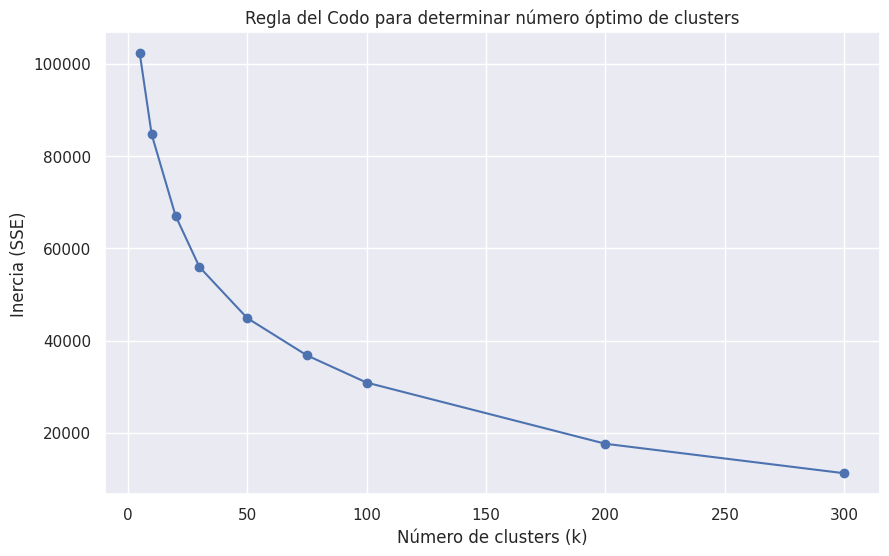

In [8]:

df_sin_cluster = df_procesado.drop(columns=['cluster'], errors='ignore')
n_clusters_list = [5, 10, 20, 30, 50, 75, 100, 200, 300]
inertias = []
for k in n_clusters_list:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_sin_cluster)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(n_clusters_list, inertias, marker='o', linestyle='-', color='b')
plt.title('Regla del Codo para determinar número óptimo de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.grid(True)
plt.show()

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [21]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [22]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



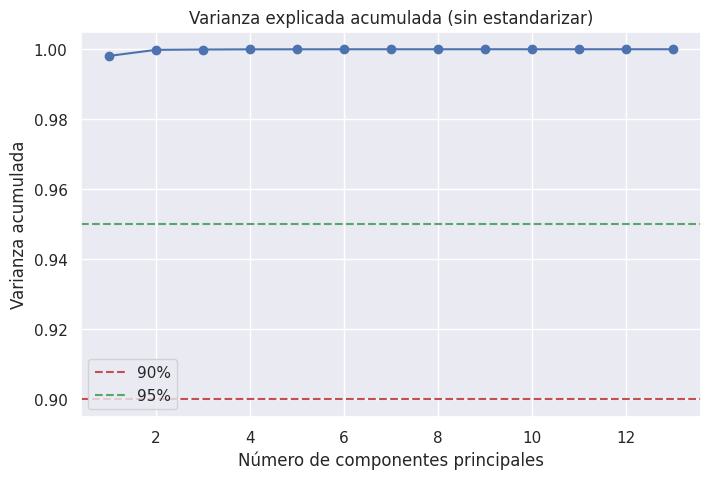

   Componente  Varianza individual  Varianza acumulada
0         PC1         9.980912e-01            0.998091
1         PC2         1.735916e-03            0.999827
2         PC3         9.495896e-05            0.999922
3         PC4         5.021736e-05            0.999972
4         PC5         1.236368e-05            0.999985
5         PC6         8.462130e-06            0.999993
6         PC7         2.806815e-06            0.999996
7         PC8         1.523081e-06            0.999997
8         PC9         1.127830e-06            0.999999
9        PC10         7.214158e-07            0.999999
10       PC11         3.780603e-07            1.000000
11       PC12         2.120138e-07            1.000000
12       PC13         8.253928e-08            1.000000


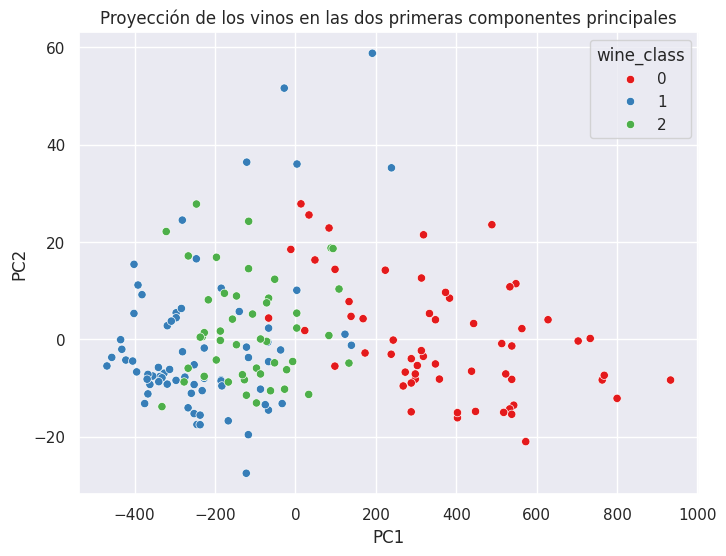

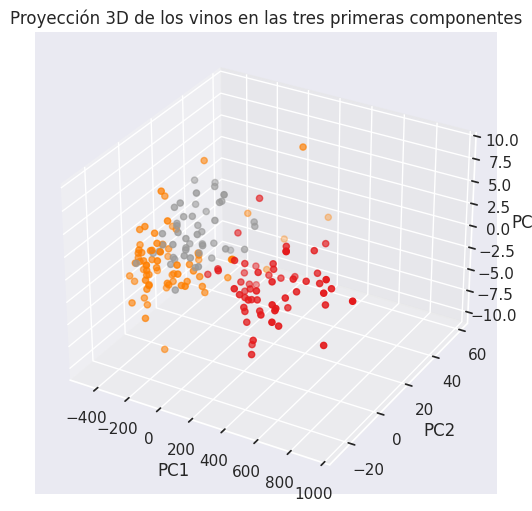


Coeficientes (loadings) de las variables originales en las tres primeras PCs:
                                   PC1       PC2       PC3
alcohol                       0.001659  0.001203  0.016874
malic_acid                   -0.000681  0.002155  0.122003
ash                           0.000195  0.004594  0.051987
alcalinity_of_ash            -0.004671  0.026450  0.938593
magnesium                     0.017868  0.999344 -0.029780
total_phenols                 0.000990  0.000878 -0.040485
flavanoids                    0.001567 -0.000052 -0.085443
nonflavanoid_phenols         -0.000123 -0.001354  0.013511
proanthocyanins               0.000601  0.005004 -0.024659
color_intensity               0.002327  0.015100  0.291398
hue                           0.000171 -0.000763 -0.025978
od280/od315_of_diluted_wines  0.000705 -0.003495 -0.070324
proline                       0.999823 -0.017774  0.004529


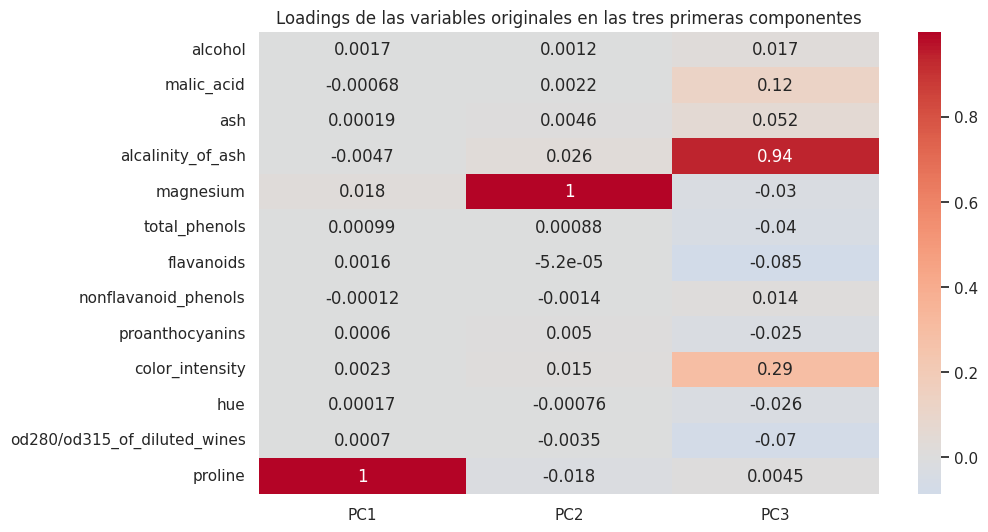


Interpretación:
- Cada componente principal es una combinación lineal de las variables originales.
- Las variables con valores (positivos o negativos) más altos en cada PC son las que más influyen.
- Si, por ejemplo, 'alcohol' y 'color_intensity' tienen altos coeficientes en PC1, esa dimensión puede asociarse a la intensidad del vino.
- Al observar las gráficas 2D o 3D, si los grupos de colores (clases de vino) se separan claramente, el PCA logra distinguir químicamente los tipos de vino.


In [16]:
X = wine[features]
y = wine[target]
pca = PCA()
pca.fit(X)

var_ind = pca.explained_variance_ratio_
var_acm = np.cumsum(var_ind)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_acm)+1), var_acm, marker='o', color='b')
plt.axhline(y=0.90, color='r', linestyle='--', label='90%')
plt.axhline(y=0.95, color='g', linestyle='--', label='95%')
plt.title('Varianza explicada acumulada (sin estandarizar)')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada')
plt.legend()
plt.grid(True)
plt.show()

tab_var = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(var_ind))],
    'Varianza individual': var_ind,
    'Varianza acumulada': var_acm
})
print(tab_var)
pca_n = PCA(n_components=3)
X_pca = pca_n.fit_transform(X)

proy = pd.DataFrame(X_pca, columns=['PC1','PC2','PC3'])
proy[target] = y
plt.figure(figsize=(8,6))
sns.scatterplot(data=proy, x='PC1', y='PC2', hue=target, palette='Set1')
plt.title('Proyección de los vinos en las dos primeras componentes principales')
plt.show()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(proy['PC1'], proy['PC2'], proy['PC3'],
           c=proy[target], cmap='Set1')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Proyección 3D de los vinos en las tres primeras componentes')
plt.show()

loadings = pd.DataFrame(
    pca_n.components_.T,
    columns=['PC1','PC2','PC3'],
    index=features
)

print("\nCoeficientes (loadings) de las variables originales en las tres primeras PCs:")
print(loadings)

plt.figure(figsize=(10,6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Loadings de las variables originales en las tres primeras componentes')
plt.show()

print("\nInterpretación:")
print("- Cada componente principal es una combinación lineal de las variables originales.")
print("- Las variables con valores (positivos o negativos) más altos en cada PC son las que más influyen.")
print("- Si, por ejemplo, 'alcohol' y 'color_intensity' tienen altos coeficientes en PC1, esa dimensión puede asociarse a la intensidad del vino.")
print("- Al observar las gráficas 2D o 3D, si los grupos de colores (clases de vino) se separan claramente, el PCA logra distinguir químicamente los tipos de vino.")



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



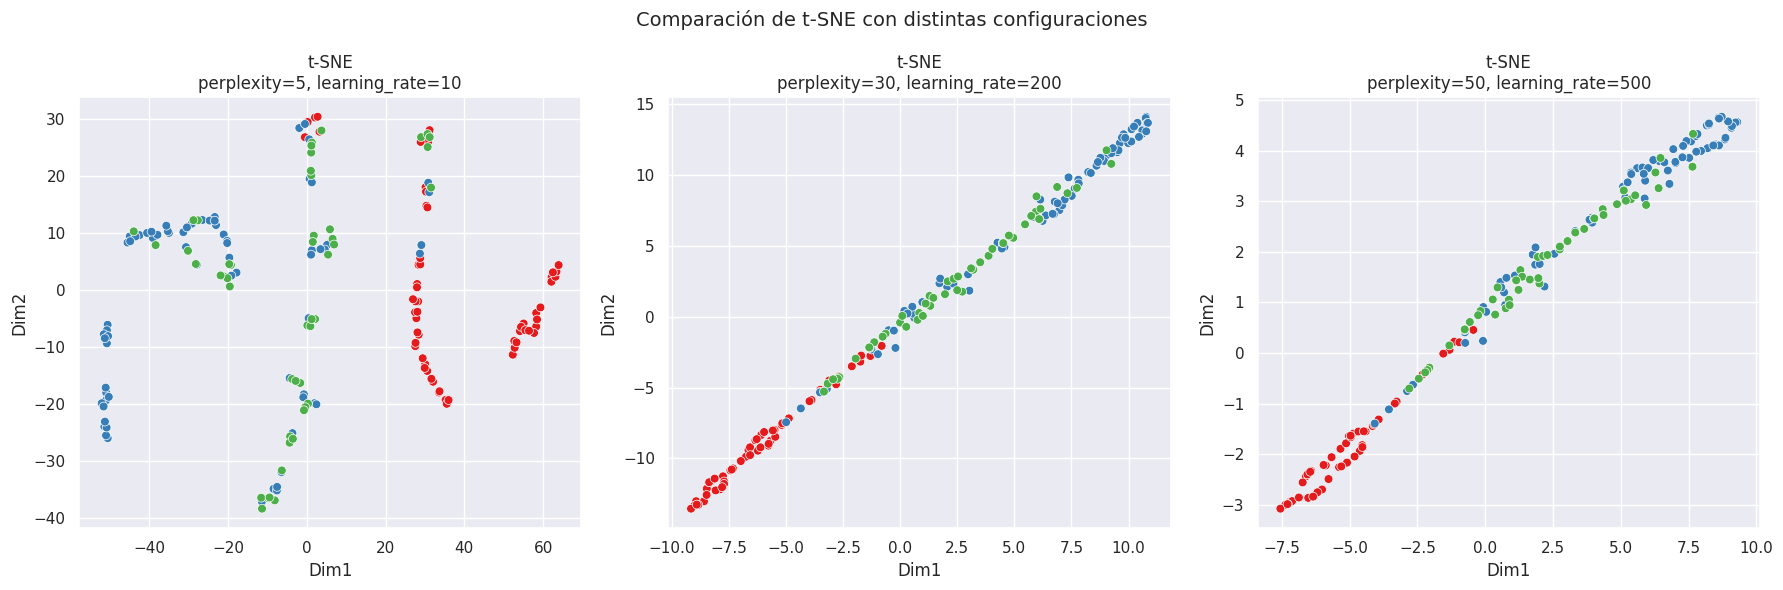


Interpretación del t-SNE:
- t-SNE busca preservar las relaciones locales entre puntos, por eso suele formar grupos o 'nubes' bien definidas.
- El hiperparámetro 'perplexity' controla el equilibrio entre relaciones locales y globales:
   * Valores bajos (ej. 5) resaltan microagrupamientos.
   * Valores medios (20–50) capturan mejor la estructura general.
- 'learning_rate' controla la velocidad de ajuste; si es muy bajo o alto puede distorsionar el mapa.
- Al comparar las visualizaciones, observa cómo cambian las separaciones entre clases.
- Si las tres clases de vino forman grupos distintos en la mayoría de configuraciones, t-SNE logra reflejar relaciones no lineales que PCA no capta totalmente.


In [17]:
configuraciones = [
    {'perplexity': 5,  'learning_rate': 10},
    {'perplexity': 30, 'learning_rate': 200},
    {'perplexity': 50, 'learning_rate': 500}
]

tsne_resultados = []

for cfg in configuraciones:
    tsne = TSNE(n_components=2, perplexity=cfg['perplexity'], learning_rate=cfg['learning_rate'], random_state=42, init='pca')
    X_tsne = tsne.fit_transform(X)
    df_tsne = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
    df_tsne[target] = y
    df_tsne['perplexity'] = cfg['perplexity']
    df_tsne['learning_rate'] = cfg['learning_rate']
    tsne_resultados.append(df_tsne)

fig, axes = plt.subplots(1, 3, figsize=(18,6))

for i, df_tsne in enumerate(tsne_resultados):
    ax = axes[i]
    sns.scatterplot(
        data=df_tsne, x='Dim1', y='Dim2',
        hue=target, palette='Set1', ax=ax, s=40
    )
    ax.set_title(f"t-SNE\nperplexity={df_tsne['perplexity'][0]}, learning_rate={df_tsne['learning_rate'][0]}")
    ax.legend().remove()

plt.suptitle("Comparación de t-SNE con distintas configuraciones", fontsize=14)
plt.tight_layout()
plt.show()
print("\nInterpretación del t-SNE:")
print("- t-SNE busca preservar las relaciones locales entre puntos, por eso suele formar grupos o 'nubes' bien definidas.")
print("- El hiperparámetro 'perplexity' controla el equilibrio entre relaciones locales y globales:")
print("   * Valores bajos (ej. 5) resaltan microagrupamientos.")
print("   * Valores medios (20–50) capturan mejor la estructura general.")
print("- 'learning_rate' controla la velocidad de ajuste; si es muy bajo o alto puede distorsionar el mapa.")
print("- Al comparar las visualizaciones, observa cómo cambian las separaciones entre clases.")
print("- Si las tres clases de vino forman grupos distintos en la mayoría de configuraciones, t-SNE logra reflejar relaciones no lineales que PCA no capta totalmente.")



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



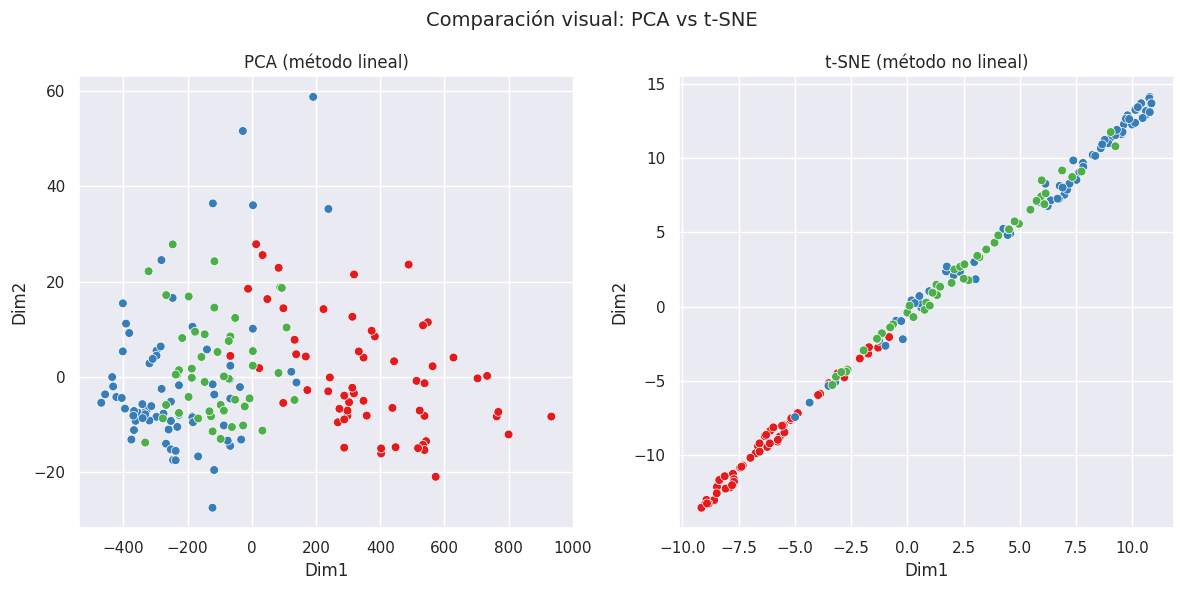

In [20]:
pca_2d = PCA(n_components=2)
X_pca2d = pca_2d.fit_transform(X)
df_pca2d = pd.DataFrame(X_pca2d, columns=['Dim1', 'Dim2'])
df_pca2d[target] = y
tsne_ref = tsne_resultados[1]
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(
    data=df_pca2d, x='Dim1', y='Dim2',
    hue=target, palette='Set1', s=40, ax=axes[0]
)
axes[0].set_title('PCA (método lineal)')
axes[0].legend().remove()
sns.scatterplot(
    data=tsne_ref, x='Dim1', y='Dim2',
    hue=target, palette='Set1', s=40, ax=axes[1]
)
axes[1].set_title('t-SNE (método no lineal)')
axes[1].legend().remove()

plt.suptitle("Comparación visual: PCA vs t-SNE", fontsize=14)
plt.tight_layout()
plt.show()